In [1]:
import os, glob
import numpy as np

from yellowbrick.target import FeatureCorrelation
from yellowbrick.features import Rank2D

from sklearn.utils import resample
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import h5py
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from GNN.utils.datautils import (
    get_data,
    balance_dataset,
    find_transition_regions
)

/cosma/local/Python/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [33]:
label = "dark_or_light"
sampling = "downsample"

# 1. Load combined features from SubFind & Sownak 

In [34]:
# arxiv:1905.08799 talks about this stellar mass cut on page 4 top right column
output_file = 'merged_dataframe.h5'                                          
data_path = '/cosma6/data/dp004/dc-cues1/tng_dataframes/'

train, test = get_data(data_path + output_file, label)
print(len(train.columns.values))

20


In [35]:
train.sample(n=3, random_state=1)

,M200_DMO,M200c,Rmax,R200c,Cnfw,Rhosnfw,Formation Time,Nmergers,MassPeak,vpeak,N_subhalos,VelDisp,Vmax,Spin,fsub_unbound,x_offset,x_dmo,y_dmo,z_dmo,labels
33967,3.222000e+11,3.222035e+11,0.025756,111.500549,9.541781,1.095388e+07,1.151545,1.0,5.354194e+11,158.870071,1.0,73.738907,132.469254,13.077200,0.007121,657.466485,265.680687,269.871812,199.033187,True
87515,1.594000e+11,1.594472e+11,0.015614,88.186943,16.635263,4.515792e+07,1.966384,1.0,2.638693e+11,116.536285,2.0,62.604664,114.830658,5.033566,0.008136,2196.179003,144.617547,260.009687,162.087938,True
14264,4.474000e+11,4.473788e+11,0.058838,124.389297,4.836464,2.172080e+06,1.044931,2.0,7.858822e+11,138.228745,9.0,74.484482,128.212570,10.046845,0.170153,1174.137065,42.755012,50.261793,204.619156,True


In [36]:
## Balance training set in the transition region                             
center_transition, end_transition = find_transition_regions(train)

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [37]:
train = balance_dataset(                                                     
    train, center_transition, end_transition, sampling
)


In [38]:
train_features = train.drop(columns="labels")                                
train_labels = train["labels"]

test_features = test.drop(columns="labels")                                
test_labels = test["labels"]

feature_names = train_features.columns.values

In [39]:
## Standarize features                                                       
scaler = StandardScaler()
scaler.fit(train_features.values)
train_features_std = scaler.transform(train_features.values)
test_features_std = scaler.transform(test_features.values)

train_labels = train_labels.values
test_labels = test_labels.values

# !!!
# notice that features and labels are np.ndarrays now
# !!!

# 2 Feature Importance

## 2.0 LDA decomposition

In [83]:
def lda_transform(
    train_features, train_labels,
    test_features, test_labels,
    arg_lda):
    """
    """
    
    if isinstance(arg_lda, (float)):
        return _lda_varlimit(
            train_features, train_labels,
            test_features, test_labels,
            arg_lda,
        )
    elif isinstance(arg_lda, (dict)):
        return _lda_dict(
            train_features, train_labels,
            test_features, test_labels,
            arg_lda,
        )


def _lda_dict(
    train_features, train_labels,
    test_features, test_labels,
    arg_lda: dict):
    """
    """
    # Create LDA
    lda = LDA(**arg_lda)
    
    # tranform features based on training dataset
    train_features = lda.fit_transform(train_features, train_labels)
    test_features = lda.transform(test_features)
    
    print("explained_variance_ratio_ ", lda.explained_variance_ratio_)
        
    return train_features, test_features, lda.n_components


def _lda_varlimit(
    train_features, train_labels,
    test_features, test_labels,
    variance_limit: float):
    """
    """
    # Create array of explained variance ratios
    lda = LDA(n_components=None)
    print(train_features.shape)
    dump = lda.fit(train_features, train_labels)
    lda_var_ratios = lda.explained_variance_ratio_
    print("explained_variance_ratio_", lda_var_ratios)
    
    # Set initial variance
    total_variance = 0.0
    # Set initial number of features
    n_components = 0
    
    # Run through explained variance of each feature:
    for explained_variance in lda_var_ratios:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        if total_variance >= variance_limit:
            break
    
    # Create LDA
    lda = LDA(n_components=n_components, priors=None)
    
    # tranform features based on training dataset
    train_features = lda.fit_transform(train_features, train_labels)
    test_features = lda.transform(test_features)
    
    # check mean accuracy
    #score_lda = lda.score(test_features, test_labels)
        
    return train_features, test_features, lda.n_components


print("Original feature space dimensions = %d \n" %
      train_features_std.shape[1])
#"""
arg_lda = 0.95
train_features_manual, test_features_manual, n_components_manual = lda_transform(
    train_features_std, train_labels,
    test_features_std, test_labels,
    arg_lda,
)
#"""
print("n_components_manual:", n_components_manual, train_features_manual.shape)
print(" ")

arg_lda = {'solver': 'eigen', 'shrinkage': 'auto'}
train_features_dict, test_features_dict, n_components_dict = lda_transform(
    train_features_std, train_labels,
    test_features_std, test_labels,
    arg_lda,
)

print("n_components_dict:", n_components_dict, train_features_dict.shape)

Original feature space dimensions = 19 

(19715, 19)
explained_variance_ratio_ [1.]
n_components_manual: 1 (19715, 1)
 
explained_variance_ratio_  [0.45722735]
n_components_dict: None (19715, 1)


/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


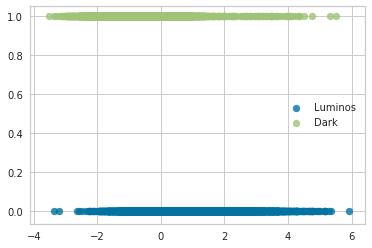

In [81]:
plt.figure()

plt.scatter(
    train_features_dict[np.where(train_labels)[0], 0],
    [0]*len(np.where(train_labels)[0]),
    alpha=.8, label='Luminos',
)
plt.scatter(
    train_features_dict[np.where(~train_labels)[0], 0],
    [1]*len(np.where(~train_labels)[0]),
    alpha=.8, label='Dark',
)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

## 2.1 Pearson correlation score

### Before LDA

In [ ]:
visualizer = Rank2D(features=feature_names, algorithm='pearson')

visualizer.fit(train_features_std, test_labels.values)
visualizer.transform(train_features_std)  
visualizer.poof()  

### After LDA - manual

In [ ]:
visualizer = Rank2D(
    features=['PCA_%d' % dd for dd in range(train_features_pca_manual.shape[1])],
    algorithm='pearson',
)

visualizer.fit(train_features_pca_manual, train_labels.values)
visualizer.transform(train_features_pca_manual)  
visualizer.poof()